In [1]:
#*************************************************************************************************************#
# Implementación de circuito Cuántico de Distribución de Clave Cuántica (QKD) en la plataforma Qiskit de IBM
#*************************************************************************************************************#

#*************************************************************************************************************#
# Para esta implementación se ha tenido en cuenta la descripción del circuito dada en el siguiente 
# tutorial del libro de Qiskit:
# https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html
#*************************************************************************************************************#

#*************************************************************************************************************#
# Taller de Computación Cuántica
# Prof. Gustavo Patino (adolfo.patino@udea.edu.co)
# CORE 2022
# CIC - IPN 
# Ciudad de México - México
# Septiembre del 2022
#*************************************************************************************************************#

In [2]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
print("Imports Successful")

Imports Successful


In [3]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

If Alice prepares a qubit in the state $|+\rangle$ (`0` in the $X$-basis), and Bob measures it in the $X$-basis, Bob is sure to measure `0`:

## 3. Qiskit Example: Without Interception

Let’s first see how the protocol works when no one is listening in, then we can see how Alice and Bob are able to detect an eavesdropper. As always, let's start by importing everything we need:

To generate pseudo-random keys, we will use the `randint` function from numpy.

In [4]:
np.random.seed()

We will call the length of Alice's initial message `n`. In this example, Alice will send a message 100 qubits long:

In [5]:
n = 100

### 3.1 Step 1:

Alice generates her random set of bits:

In [6]:
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0
 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1
 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1]


At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Eve's channel in a table like this:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

### 3.2 Step 2:

Alice chooses to encode each bit on qubit in the $X$ or $Z$-basis at random, and stores the choice for each qubit in `alice_bases`. In this case, a `0` means "prepare in the $Z$-basis", and a `1` means "prepare in the $X$-basis":

In [7]:
## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0
 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1]


In [8]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: 
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: 
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

Alice also keeps this knowledge private:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |     &nbsp;      |

The function `encode_message` below, creates a list of `QuantumCircuit`s, each representing a single qubit in Alice's message:

In [9]:
message = encode_message(alice_bits, alice_bases)

In [10]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 0


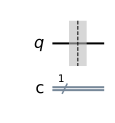

In [11]:
message[0].draw('mpl')

bit = 0
basis = 1


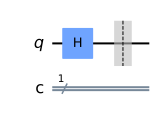

In [12]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw('mpl')

This message of qubits is then sent to Bob over Eve's quantum channel:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

### 3.3 Step 3:

Bob then measures each qubit in the $X$ or $Z$-basis at random and stores this information:

In [13]:
## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0]


`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |
|                   |                  |    bob_bases    |

Below, the function `measure_message` applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_results`.

In [14]:
def bob_measure(bases):
    measurements = []
    for q in range(n):
        qc = QuantumCircuit(1,1)        
        if bases[q] == 0: 
            qc.measure(0,0)
        if bases[q] == 1: 
            qc.h(0)
            qc.measure(0,0)
        measurements.append(qc)            
    return measurements

In [15]:
measurements=bob_measure(bob_bases)

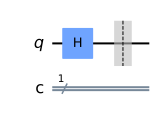

In [16]:
message[4].draw('mpl')

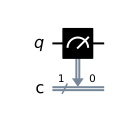

In [17]:
measurements[4].draw('mpl')

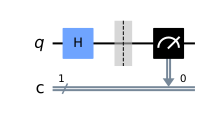

In [18]:
circ_t=message[4].compose(measurements[4])
circ_t.draw('mpl')

In [19]:
def exec_simulation(message, measurements):
    backend = Aer.get_backend('aer_simulator')
    results = []
    for q in range(n):
        full_circuit=message[q].compose(measurements[q])
        qobj = assemble(full_circuit, shots=1, memory=True)
        result = backend.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        results.append(measured_bit)
    return results

In [20]:
bob_results = exec_simulation(message, measurements)
print(bob_results)

[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Bob keeps his results private.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |

### 3.4 Step 4:

After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis: 

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |

And Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_results` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function `remove_garbage` that does this for us:

In [21]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

In [22]:
## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     &nbsp;      |

In [23]:
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |

### 3.5 Step 5:

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [24]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [25]:
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
alice_sample = [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |

If the protocol has worked correctly without interference, their samples should match:

In [26]:
bob_sample == alice_sample

True

If their samples match, it means (with high probability) `alice_key == bob_key`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|     shared_key    |                    |    shared_key   |

In [27]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
key length = 37


In [28]:
AKeStringInts = [str(int) for int in alice_key]
Akey = "".join(AKeStringInts)
print(Akey)

1100010010101000101011000001011100111


In [29]:
BKeStringInts = [str(int) for int in bob_key]
Bkey = "".join(BKeStringInts)
print(Bkey)

1100010010101000101011000001011100111


In [30]:
#Super secret message
mes = '....increible! CDMX es enorme!.....'
print('Tu mensaje supersecreto a ser comunicado es : ',mes)

#initial size of key
n = len(mes)*3

#break up message into smaller parts if length > 10
nlist = []
for i in range(int(n/10)):
    nlist.append(10)
if n%10 != 0:
    nlist.append(n%10)

print('El tamaño inicial del mensaje secreto es: ',n)

Tu mensaje supersecreto a ser comunicado es :  ....increible! CDMX es enorme!.....
El tamaño inicial del mensaje secreto es:  105


In [31]:
#make key same length has message
shortened_Akey = Akey[:len(mes)]
encoded_m=''

#encrypt message mes using encryption key final_key
for m,k in zip(mes,shortened_Akey):
    encoded_c = chr(ord(m) + 2*ord(k) % 256)
    encoded_m += encoded_c
print('El mensaje codificado es:  ',encoded_m)

El mensaje codificado es:   ÉÐÃÒÇÉÄÌÇ£¦­ºÇÕÅÎÏÒÏÅ


In [32]:
#### *************************************** ####
# Aqui se envía el mensaje secreto codificado....
#### *************************************** ####

In [33]:
#make key same length has message
shortened_Bkey = Bkey[:len(mes)]

#decrypt message mes using encryption key final_key
result = ''
for m,k in zip(encoded_m,shortened_Bkey):
    encoded_c = chr(ord(m) - 2*ord(k) % 256)
    result += encoded_c
    

In [34]:
print('recovered message:',result)

recovered message: ....increible! CDMX es enorme!.....


In [35]:
import qiskit.tools.jupyter
%qiskit_version_table